<a href="https://colab.research.google.com/github/amazzoli/Quantitative_immunology/blob/main/notebooks/Exp_max_mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def plot_mixture(ax1, ax2, x_a, x_b, theta, line_styles='solid'):

  p_a, mu_a, mu_b, sig_a, sig_b = theta
  xs = np.append(x_a, x_b)
  ax1.scatter(x_a, np.zeros(len(x_a)), marker='x')
  ax1.scatter(x_b, np.zeros(len(x_b))+0.01, marker='+')

  ax1.set_ylabel('pdf')
  x_norm_a = np.linspace(mu_a - 2.5*sig_a, mu_a + 2.5*sig_a, 100)
  ax1.plot(x_norm_a, norm.pdf(x_norm_a, mu_a, sig_a) * p_a)
  x_norm_b = np.linspace(mu_b - 2.5*sig_b, mu_b + 2.5*sig_b, 100)
  ax1.plot(x_norm_b, norm.pdf(x_norm_b, mu_b, sig_b) * (1 - p_a), ls=line_styles)

  ax2.set_xlabel('x')
  ax2.set_ylabel('pdf')
  x_norm_mix = np.linspace(min(xs), max(xs), 200)
  ys = norm.pdf(x_norm_mix, mu_b, sig_b) * (1 - p_a) + norm.pdf(x_norm_mix, mu_a, sig_a) * p_a
  ax2.scatter(xs, np.zeros(len(xs)), alpha=0.5)
  ax2.plot(x_norm_mix, ys)

  return ax1, ax2

# Expectation-maximization algorithm for gaussian mixtures

We generate a set of $N$ one-dimesional points from two gaussian distributions, $\mathcal{N}(x|\mu_a, \sigma_a)$ and $\mathcal{N}(x|\mu_b, \sigma_b)$, where each point has probability $p_a$ to be generated from the first gaussian and $1-p_a$ from the second.


The model has 5 parameters: 
$\theta = (p_a, \mu_a, \mu_b, \sigma_a, \sigma_b)$

\begin{equation}
P(x_i | \theta) = p_a \mathcal{N}(x_i|\mu_a, \sigma_a) + (1-p_a)\mathcal{N}(x_i|\mu_b, \sigma_b)
\end{equation}


### True parameters of the model

In [8]:
p_a_true = 0.4
mu_a_true, mu_b_true = -1, 1
sig_a_true, sig_b_true = 1, 0.5
theta_true = (p_a_true, mu_a_true, mu_b_true, sig_a_true, sig_b_true)

### Generating the sample

In [9]:
N = 100
n_samples_a = np.random.binomial(N, p_a_true)
n_samples_b = N - n_samples_a

# Points from gaussian a
x_a = np.random.normal(mu_a_true, sig_a_true, size=n_samples_a)

# Points from gaussian b
x_b = np.random.normal(mu_b_true, sig_b_true, size=n_samples_b)

# All points together
xs = np.append(x_a, x_b)
xs = np.random.shuffle(xs)

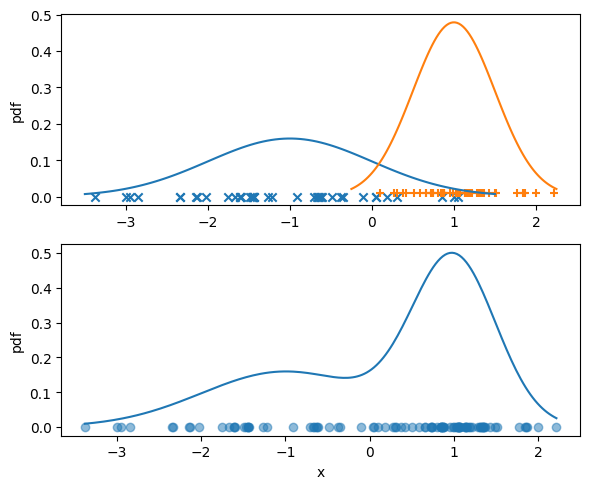

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,5))
plot_mixture(ax1, ax2, x_a, x_b, theta_true)
plt.tight_layout()

### Inference of the parameters through expectation-maximization

Now we want to infer back the paramters of the model using the $N$ samples that have been generated.
We can see that the model can be written in terms of latent variables $a$ or $b$ of the point being generated from the first or second gaussian.

\begin{equation}
\begin{aligned}
P(x_i | \theta)& = \sum_z P(x_i, z | \theta) 
\\
&  = P(x_i, a | \theta) + P(x_i, b | \theta) 
\\
&  = P(x_i | a, \theta)p(a | \theta) + P(x_i | b, \theta)p(b|\theta) 
\\
&  = \mathcal{N}(x_i|\mu_a, \sigma_a) p_a  + \mathcal{N}(x_i|\mu_b, \sigma_b) (1-p_a)
\end{aligned}
\end{equation}

This structure allows us to use the expectation maximization algorithm, and write the pseudo-likelihood

\begin{equation}
\begin{aligned}
Q(\mathbf{x}|θ', θ) & = \sum_{i=1}^N \sum_z P(z|x_i\theta) \log P(x_i,z|\theta')
\\
&  = \sum_{i=1}^N  P(a | x_i, \theta) \log P(x_i,a|\theta') + P(b | x_i, \theta) \log P(x_i,b|\theta')
\\
&  = \sum_{i=1}^N  P(a | x_i, \theta) \left ( \log P(x_i | a, \theta') + \log P(a|\theta') \right) + P(b | x_i, \theta) \left ( \log P(x_i | b, \theta') + \log P(b|\theta') \right)
\\
&  = \sum_{i=1}^N  P(a | x_i, \theta) \left ( \log  \mathcal{N}(x_i|\mu_a', \sigma_a') + \log p_a' \right) + P(b | x_i, \theta) \left ( \log \mathcal{N}(x_i|\mu_b', \sigma_b') + \log p_b' \right), 
\end{aligned}
\end{equation}
where, using the Bayes theorem,
\begin{equation}
P(a | x_i, \theta) = \frac{P(x_i | a, \theta) P(a|\theta)}{P(x_i|\theta)} = \frac{\mathcal{N}(x_i|\mu_a, \sigma_a) p_a}{P(x_i|\theta)} ,
\end{equation}
and similarly for $P(b|x_i, \theta)$.

By knowing the pseudo-likelihood, we can find the maximum among the parameters $\theta'$ given $\theta$ thorugh its stationary points.
By doing all the derivatives, we find:
\begin{equation}
\mu_a'^* = \frac{\sum_{i=1}^N  P(a | x_i, \theta) x_i}{\sum_{i=1}^N  P(a | x_i, \theta)}
\end{equation}
\begin{equation}
(\sigma_a'^*)^2 = \frac{\sum_{i=1}^N  P(a | x_i, \theta) (x_i - \mu_a)^2}{\sum_{i=1}^N  P(a | x_i, \theta)}
\end{equation}
\begin{equation}
p_a'^* = \frac{\sum_{i=1}^N  P(a | x_i, \theta)}{N}
\end{equation}
and similarly for $\mu_b'^*$ and $\sigma_b'^*$.
It is interesting to see that they look like weighted averages (and variances), where the weight is the estimated probability of belonging to the proper gaussian distribution.

Below, these update rules are implemented

In [13]:
def update_pars(xs, theta):

  p_a, mu_a, mu_b, sig_a, sig_b = theta

  # Normal distributions
  norm_x_given_a = norm.pdf(xs, mu_a, sig_a)
  norm_x_given_b = norm.pdf(xs, mu_b, sig_b)

  # Probability of the sequence
  p_x = norm_x_given_a * p_a + norm_x_given_b * (1 - p_a)

  # P(a | x_i, theta)
  p_a_given_x = norm_x_given_a * p_a / p_x
  p_b_given_x = norm_x_given_b * (1 - p_a) / p_x

  # \sum_i P(a | x_i, theta)
  p_a_given_x_sum = p_a_given_x.sum()
  p_b_given_x_sum = p_b_given_x.sum()

  # Update rules
  new_mu_a = np.sum(p_a_given_x * xs) / p_a_given_x_sum
  new_mu_b = np.sum(p_b_given_x * xs) / p_b_given_x_sum
  new_sig_a = np.sqrt(np.sum(p_a_given_x * (xs - mu_a)**2) / p_a_given_x_sum)
  new_sig_b = np.sqrt(np.sum(p_b_given_x * (xs - mu_b)**2) / p_b_given_x_sum)
  new_p_a = p_a_given_x_sum / len(xs)

  return (new_p_a, new_mu_a, new_mu_b, new_sig_a, new_sig_b), np.sum(np.log(p_x))

### Initial guesses of the parameters

In [15]:
p_a_start = 0.5
mu_a_start, mu_b_start = -2, 2
sig_a_start, sig_b_start = 1, 1
theta_start = (p_a_start, mu_a_start, mu_b_start, sig_a_start, sig_b_start)

### Iteration of the update rule until convergence

In [16]:
thetas, log_likes = [theta_start], [0]
delta_log_like_max = 0.1

for _ in range(30):
  theta, log_like = update_pars(xs, thetas[-1])
  thetas.append(theta)
  log_likes.append(log_like)
  if np.abs(log_likes[-1] - log_likes[-2]) < delta_log_like_max:
    break

log_likes = np.array(log_likes[1:])

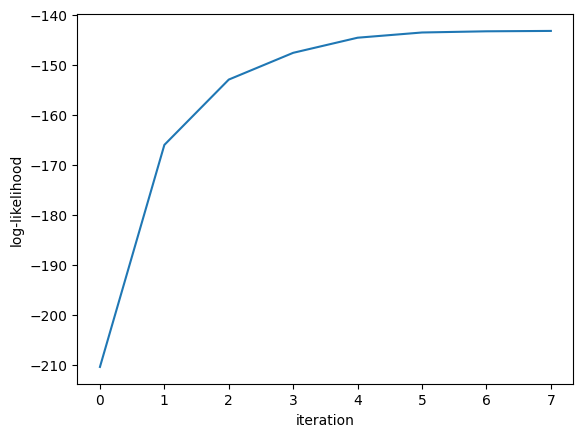

In [17]:
plt.xlabel('iteration')
plt.ylabel('log-likelihood')
plt.plot(log_likes)

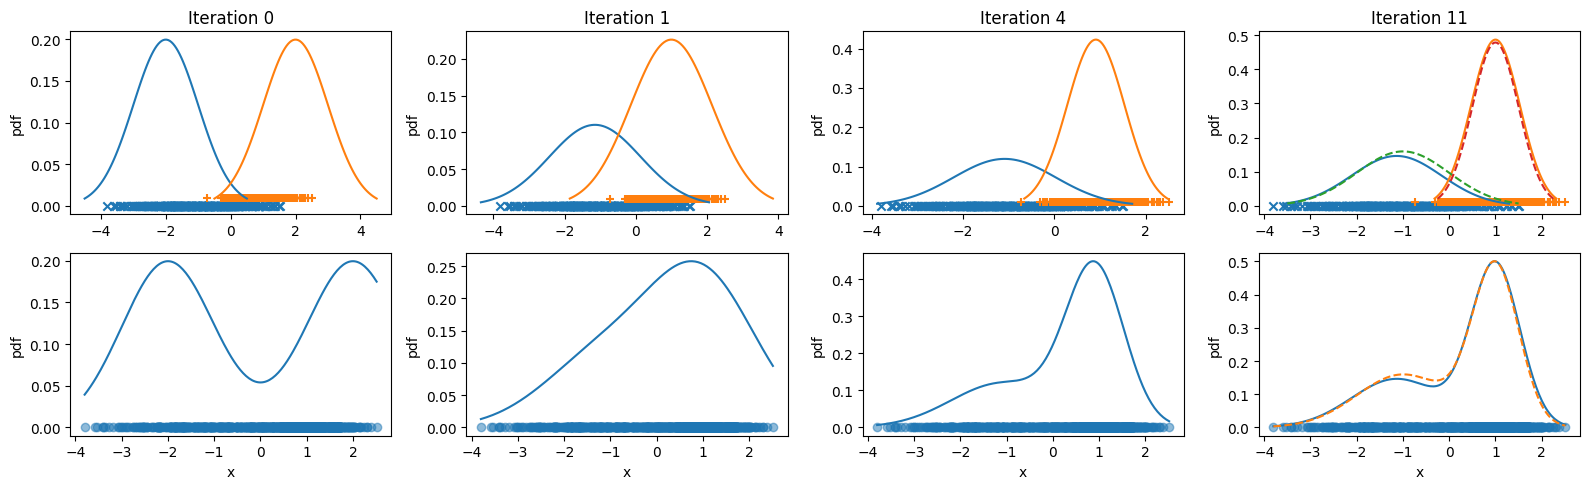

In [ ]:
iter_to_plot = [0, 1, 4, len(thetas)-1]
fig, axs = plt.subplots(2, len(iter_to_plot), figsize=(4*len(iter_to_plot), 5))

for i_plot, i in enumerate(iter_to_plot):
  axs[0][i_plot].set_title('Iteration %g'%i)
  plot_mixture(axs[0][i_plot],axs[1][i_plot], x_a, x_b, thetas[i])

p_a, mu_a, mu_b, sig_a, sig_b = theta_true
x_norm_a = np.linspace(mu_a - 2.5*sig_a, mu_a + 2.5*sig_a, 100)
axs[0][-1].plot(x_norm_a, norm.pdf(x_norm_a, mu_a, sig_a) * p_a, ls='--')
x_norm_b = np.linspace(mu_b - 2.5*sig_b, mu_b + 2.5*sig_b, 100)
axs[0][-1].plot(x_norm_b, norm.pdf(x_norm_b, mu_b, sig_b) * (1 - p_a), ls='--')
x_norm_mix = np.linspace(min(xs), max(xs), 200)
ys = norm.pdf(x_norm_mix, mu_b, sig_b) * (1 - p_a) + norm.pdf(x_norm_mix, mu_a, sig_a) * p_a
axs[1][-1].plot(x_norm_mix, ys, ls='--')

plt.tight_layout()